In [1]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

## Empezamos configurando Spark

In [2]:
conf = (SparkConf()
            .setMaster("yarn")
            .set("spark.executor.cores", 5)
            .set("spark.sql.shuffle.partitions", 200)
            .set("spark.default.parallelism", 200)
            .set("spark.executor.memory", "7g")
            .set("spark.dynamicAllocation.maxExecutors", 20)
        )

spark = SparkSession \
    .builder \
    .config(conf=conf) \
    .appName("Test_PySpark") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Creación de un DataFrame a partir de los datos almacenados en HDFS de la capa Bronze

In [4]:
df = spark.read \
          .option("header","true") \
          .option("inferSchema", "true") \
          .csv("/datos/gittba26/gittba05/Bronze/BNB")

In [5]:
df.printSchema()

root
 |-- datetime: timestamp (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



In [6]:
df.show()

+-------------------+------+------+------+------+---------+----+-----+
|           datetime|  open|  high|   low| close|   volume|year|month|
+-------------------+------+------+------+------+---------+----+-----+
|2025-10-01 02:00:00|1008.9|1036.4|1003.5|1027.1| 14695.68|2025|   10|
|2025-10-02 02:00:00|1028.2|1099.5|1023.1|1090.8|20843.915|2025|   10|
|2025-10-03 02:00:00|1090.2|1192.7|1084.5|1189.7|44120.044|2025|   10|
|2025-10-04 02:00:00|1189.8|1190.6|1136.3|1151.0|  18602.3|2025|   10|
|2025-10-05 02:00:00|1151.1|1187.9|1144.2|1167.5|13627.366|2025|   10|
|2025-10-06 02:00:00|1167.5|1239.6|1162.9|1223.7|28499.434|2025|   10|
|2025-10-07 02:00:00|1223.7|1355.1|1205.5|1304.8|74441.805|2025|   10|
|2025-10-08 02:00:00|1305.9|1334.5|1265.2|1308.2|  56335.5|2025|   10|
|2025-10-09 02:00:00|1308.0|1318.7|1225.0|1255.9|62487.178|2025|   10|
|2025-10-10 02:00:00|1256.1|1280.9| 891.1|1104.3| 94237.71|2025|   10|
|2025-10-11 02:00:00|1102.0|1183.4|1077.9|1136.8|52931.492|2025|   10|
|2025-

In [7]:
df.count()

1461

In [12]:
!hdfs dfs -ls /datos/gittba26/gittba05/Bronze/BNB

Found 4 items
drwxr-xr-x   - gittba_bdt09 supergroup          0 2026-01-28 19:44 /datos/gittba26/gittba05/Bronze/BNB/year=2022
drwxr-xr-x   - gittba_bdt09 supergroup          0 2026-01-28 19:44 /datos/gittba26/gittba05/Bronze/BNB/year=2023
drwxr-xr-x   - gittba_bdt09 supergroup          0 2026-01-28 19:44 /datos/gittba26/gittba05/Bronze/BNB/year=2024
drwxr-xr-x   - gittba_bdt09 supergroup          0 2026-01-28 19:44 /datos/gittba26/gittba05/Bronze/BNB/year=2025


## Creamos los parquets de la capa Silver a partir de los .CSV de la capa Bronze

In [17]:
silver_path = "/datos/gittba26/gittba05/Silver/BNB"

df.write \
  .mode("overwrite") \
  .partitionBy("year", "month") \
  .parquet(silver_path)

## Leemos los parquets para comprobar que se han guardado bien

In [18]:
silver_path = "/datos/gittba26/gittba05/Silver/BNB"

df_silver = spark.read.parquet(silver_path)

# Lista de particiones (año, mes) en Silver
df_silver.select("year","month").distinct().orderBy("year","month").show(200, truncate=False)

[Stage 10:===========================================>            (37 + 5) / 48]

+----+-----+
|year|month|
+----+-----+
|2022|1    |
|2022|2    |
|2022|3    |
|2022|4    |
|2022|5    |
|2022|6    |
|2022|7    |
|2022|8    |
|2022|9    |
|2022|10   |
|2022|11   |
|2022|12   |
|2023|1    |
|2023|2    |
|2023|3    |
|2023|4    |
|2023|5    |
|2023|6    |
|2023|7    |
|2023|8    |
|2023|9    |
|2023|10   |
|2023|11   |
|2023|12   |
|2024|1    |
|2024|2    |
|2024|3    |
|2024|4    |
|2024|5    |
|2024|6    |
|2024|7    |
|2024|8    |
|2024|9    |
|2024|10   |
|2024|11   |
|2024|12   |
|2025|1    |
|2025|2    |
|2025|3    |
|2025|4    |
|2025|5    |
|2025|6    |
|2025|7    |
|2025|8    |
|2025|9    |
|2025|10   |
|2025|11   |
|2025|12   |
+----+-----+



In [19]:
# Verificamos que hay el mismo número de ficheros en la capa Bronze y en la Silver
bronze_path = "/datos/gittba26/gittba05/Bronze/BNB"

df_bronze = spark.read.option("header","true").option("inferSchema","true").csv(bronze_path)

print("Rows Bronze:", df_bronze.count())
print("Rows Silver:", df_silver.count())

Rows Bronze: 1461
Rows Silver: 1461


## Empezamos el análisis con los parquets de la capa Silver

### 1) PLATA → leer Parquet

In [23]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

SILVER_PATH = "/datos/gittba26/gittba05/Silver/BNB"
GOLD_PATH   = "/datos/gittba26/gittba05/Gold/BNB_kpis"

df = spark.read.parquet(SILVER_PATH)

df = (df
      .withColumn("datetime", F.to_timestamp("datetime"))
      .withColumn("close", F.col("close").cast("double"))
      .select("datetime","close","year","month")
      .orderBy("datetime")
     )

df.show(5, truncate=False)
df.printSchema()

[Stage 26:>                                                        (0 + 5) / 48]

+-------------------+-----+----+-----+
|datetime           |close|year|month|
+-------------------+-----+----+-----+
|2022-01-01 01:00:00|527.7|2022|1    |
|2022-01-02 01:00:00|531.4|2022|1    |
|2022-01-03 01:00:00|511.8|2022|1    |
|2022-01-04 01:00:00|507.0|2022|1    |
|2022-01-05 01:00:00|474.1|2022|1    |
+-------------------+-----+----+-----+
only showing top 5 rows

root
 |-- datetime: timestamp (nullable = true)
 |-- close: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



### 2) KPI 1 — SMA 200 (exacta)

In [61]:
N_SMA = 200
w_sma200 = Window.orderBy("datetime").rowsBetween(-(N_SMA-1), 0)

df = df.withColumn("SMA_200", F.avg("close").over(w_sma200))

### 3) KPI 2 — EMA 50

In [62]:
# Creamos un índice ordenado
df_idx = df.withColumn("idx", F.row_number().over(Window.orderBy("datetime")))

alpha = 2/(50+1)

# Convertimos a una lista ordenada (collect_list sobre struct idx)
arr_df = df_idx.agg(
    F.sort_array(F.collect_list(F.struct("idx","datetime","close","year","month","SMA_200"))).alias("arr")
)

In [65]:
# Calcular EMA50 recursiva con aggregate
from pyspark.sql import functions as F
from pyspark.sql.window import Window

alpha50 = 2/(50+1)

df_idx = df.withColumn("idx", F.row_number().over(Window.orderBy("datetime")))

arr_df = df_idx.agg(
    F.sort_array(
        F.collect_list(F.struct("idx","datetime","close","year","month","SMA_200"))
    ).alias("arr")
)

# acumulador tipado: cast(array() as array<double>)
ema50_expr = F.expr(f"""
aggregate(
  arr,
  cast(array() as array<double>),
  (acc, x) -> concat(
    acc,
    array(
      case
        when size(acc)=0 then x.close
        else {alpha50}*x.close + (1-{alpha50})*element_at(acc, -1)
      end
    )
  )
)
""")

out_df = (arr_df
    .select("arr", ema50_expr.alias("ema50_arr"))
    .select(
        F.posexplode("arr").alias("pos","x"),
        F.col("ema50_arr")[F.col("pos")].alias("EMA_50")
    )
    .select(
        F.col("x.datetime").alias("datetime"),
        F.col("x.close").alias("close"),
        F.col("x.SMA_200").alias("SMA_200"),
        F.col("EMA_50"),
        F.col("x.year").alias("year"),
        F.col("x.month").alias("month")
    )
    .orderBy("datetime")
)

out_df.show(5, truncate=False)

[Stage 125:>                                                        (0 + 1) / 1]

+-------------------+-----+-----------------+-----------------+----+-----+
|datetime           |close|SMA_200          |EMA_50           |year|month|
+-------------------+-----+-----------------+-----------------+----+-----+
|2022-01-01 01:00:00|527.7|527.7            |527.7            |2022|1    |
|2022-01-02 01:00:00|531.4|529.55           |527.8450980392157|2022|1    |
|2022-01-03 01:00:00|511.8|523.6333333333333|527.2158785082661|2022|1    |
|2022-01-04 01:00:00|507.0|519.4749999999999|526.4230989589223|2022|1    |
|2022-01-05 01:00:00|474.1|510.3999999999999|524.371212725239 |2022|1    |
+-------------------+-----+-----------------+-----------------+----+-----+
only showing top 5 rows



### 4) KPI 3 — RSI (14)

In [67]:
w_lag = Window.orderBy("datetime")
w14 = Window.orderBy("datetime").rowsBetween(-13, 0)

out_df = (out_df
    .withColumn("prev_close", F.lag("close", 1).over(w_lag))
    .withColumn("delta", F.col("close") - F.col("prev_close"))
    .withColumn("gain", F.when(F.col("delta") > 0, F.col("delta")).otherwise(F.lit(0.0)))
    .withColumn("loss", F.when(F.col("delta") < 0, -F.col("delta")).otherwise(F.lit(0.0)))
    .withColumn("avg_gain_14", F.avg("gain").over(w14))
    .withColumn("avg_loss_14", F.avg("loss").over(w14))
    .withColumn(
        "RSI_14",
        F.when(F.col("avg_loss_14") == 0, F.lit(100.0))
         .otherwise(100 - (100 / (1 + (F.col("avg_gain_14") / F.col("avg_loss_14")))))
    )
)

### 5) KPI 4 — MACD

In [68]:
# Helper para EMA recursiva exacta
def add_ema_recursive_exact(df_base, period, out_col):
    a = 2/(period+1)

    df_idx = df_base.withColumn("idx", F.row_number().over(Window.orderBy("datetime")))

    arr_df = df_idx.agg(
        F.sort_array(
            F.collect_list(
                F.struct(*df_idx.columns)   # guarda todas las columnas por fila
            )
        ).alias("arr")
    )

    ema_expr = F.expr(f"""
    aggregate(
      arr,
      cast(array() as array<double>),
      (acc, x) -> concat(
        acc,
        array(
          case
            when size(acc)=0 then x.close
            else {a}*x.close + (1-{a})*element_at(acc, -1)
          end
        )
      )
    )
    """)

    # reconstruimos dataframe (todas cols + nueva EMA)
    df_out = (arr_df
        .select("arr", ema_expr.alias("ema_arr"))
        .select(F.posexplode("arr").alias("pos","x"), F.col("ema_arr")[F.col("pos")].alias(out_col))
        .select("x.*", out_col)
        .drop("idx")  # por si lo traía
        .orderBy("datetime")
    )
    return df_out

In [69]:
# Calcular EMA12 y EMA26 y MACD_line
tmp = add_ema_recursive_exact(out_df, 12, "EMA_12")
tmp = add_ema_recursive_exact(tmp, 26, "EMA_26")

df_kpis = (tmp
    .withColumn("MACD_line", F.col("EMA_12") - F.col("EMA_26"))
    .select("datetime","close","SMA_200","EMA_50","RSI_14","MACD_line","year","month")
    .orderBy("datetime")
)

df_kpis.show(5, truncate=False)

[Stage 132:>                                                        (0 + 1) / 1]

+-------------------+-----+-----------------+-----------------+------------------+-------------------+----+-----+
|datetime           |close|SMA_200          |EMA_50           |RSI_14            |MACD_line          |year|month|
+-------------------+-----+-----------------+-----------------+------------------+-------------------+----+-----+
|2022-01-01 01:00:00|527.7|527.7            |527.7            |100.0             |0.0                |2022|1    |
|2022-01-02 01:00:00|531.4|529.55           |527.8450980392157|100.0             |0.29515669515672016|2022|1    |
|2022-01-03 01:00:00|511.8|523.6333333333333|527.2158785082661|15.879828326180032|-1.0404915544517053|2022|1    |
|2022-01-04 01:00:00|507.0|519.4749999999999|526.4230989589223|13.167259786476663|-2.4579881425556778|2022|1    |
|2022-01-05 01:00:00|474.1|510.3999999999999|524.371212725239 |6.06557377049171  |-6.165052556112187 |2022|1    |
+-------------------+-----+-----------------+-----------------+------------------+------

### 6) Guardar en ORO (Parquet particionado por year/month)

In [70]:
GOLD_PATH = "/datos/gittba26/gittba05/Gold/BNB_kpis"

!hdfs dfs -mkdir -p /datos/gittba26/gittba05/Gold

(df_kpis.write
   .mode("overwrite")
   .partitionBy("year","month")
   .parquet(GOLD_PATH))

!hdfs dfs -ls {GOLD_PATH}

Found 5 items
-rw-r--r--   3 gittba_bdt24 supergroup          0 2026-02-09 18:23 /datos/gittba26/gittba05/Gold/BNB_kpis/_SUCCESS
drwxr-xr-x   - gittba_bdt24 supergroup          0 2026-02-09 18:23 /datos/gittba26/gittba05/Gold/BNB_kpis/year=2022
drwxr-xr-x   - gittba_bdt24 supergroup          0 2026-02-09 18:23 /datos/gittba26/gittba05/Gold/BNB_kpis/year=2023
drwxr-xr-x   - gittba_bdt24 supergroup          0 2026-02-09 18:23 /datos/gittba26/gittba05/Gold/BNB_kpis/year=2024
drwxr-xr-x   - gittba_bdt24 supergroup          0 2026-02-09 18:23 /datos/gittba26/gittba05/Gold/BNB_kpis/year=2025


### 7) Checks rápidos

In [71]:
# RSI rango
df_kpis.select(F.min("RSI_14").alias("min_RSI"), F.max("RSI_14").alias("max_RSI")).show()

# últimas filas para comparar con TradingView
df_kpis.orderBy(F.desc("datetime")).show(10, truncate=False)

+-----------------+-------+
|          min_RSI|max_RSI|
+-----------------+-------+
|3.520456707897182|  100.0|
+-----------------+-------+



[Stage 160:>                                                        (0 + 1) / 1]

+-------------------+-----+-----------------+-----------------+------------------+-------------------+----+-----+
|datetime           |close|SMA_200          |EMA_50           |RSI_14            |MACD_line          |year|month|
+-------------------+-----+-----------------+-----------------+------------------+-------------------+----+-----+
|2025-12-31 01:00:00|863.4|884.7305000000005|890.5370639151233|57.8052550231839  |-9.788927321705728 |2025|12   |
|2025-12-30 01:00:00|860.9|883.6445000000004|891.6446991769651|45.386064030131806|-11.487619802160566|2025|12   |
|2025-12-29 01:00:00|851.5|882.6180000000005|892.8995848576576|47.81043791241753 |-13.234131007364226|2025|12   |
|2025-12-28 01:00:00|859.2|881.6365000000004|894.5893638314395|44.87612612612614 |-14.313727040080835|2025|12   |
|2025-12-27 01:00:00|844.8|880.6790000000004|896.0338276612941|35.74165298303228 |-16.267484492164954|2025|12   |
|2025-12-26 01:00:00|834.3|879.8230000000004|898.1250043005306|37.31980779498131 |-17.05

### 8) VISUALIZACIÓN

In [72]:
import matplotlib.pyplot as plt

df_plot = (df_kpis
           .filter(F.col("year")==2022)
           .select("datetime","close","SMA_200","EMA_50","RSI_14","MACD_line")
           .orderBy("datetime"))

pdf = df_plot.toPandas()

#### Plot 1: Close + SMA200 + EMA50

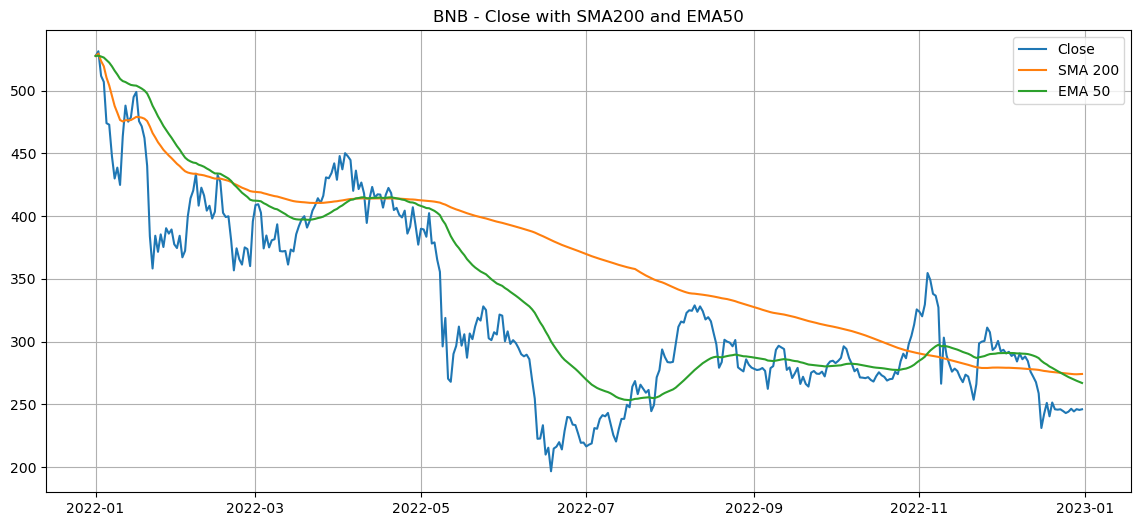

In [73]:
plt.figure(figsize=(14,6))
plt.plot(pdf["datetime"], pdf["close"], label="Close")
plt.plot(pdf["datetime"], pdf["SMA_200"], label="SMA 200")
plt.plot(pdf["datetime"], pdf["EMA_50"], label="EMA 50")
plt.title("BNB - Close with SMA200 and EMA50")
plt.legend(); plt.grid(True); plt.show()

#### Plot 2: RSI

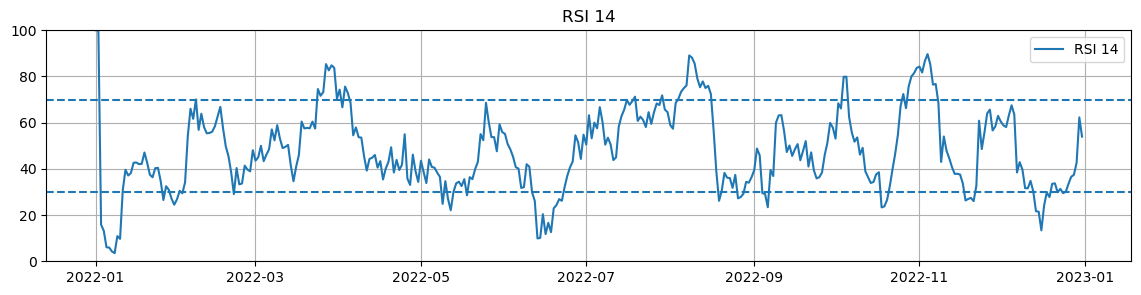

In [74]:
plt.figure(figsize=(14,3))
plt.plot(pdf["datetime"], pdf["RSI_14"], label="RSI 14")
plt.axhline(70, linestyle="--")
plt.axhline(30, linestyle="--")
plt.ylim(0,100)
plt.title("RSI 14")
plt.legend(); plt.grid(True); plt.show()

#### Plot 3: MACD

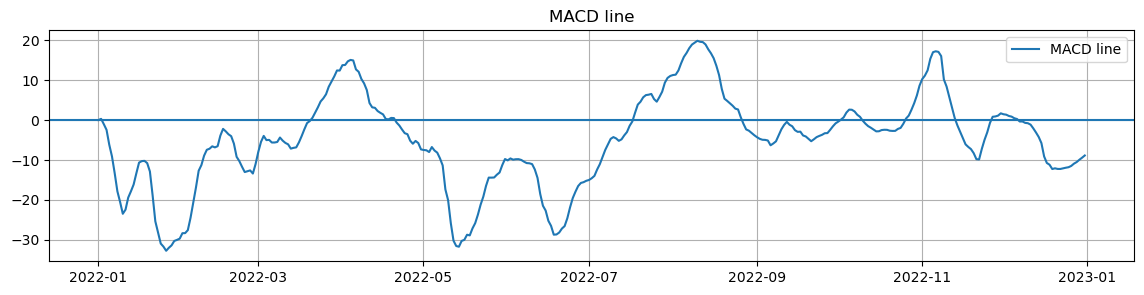

In [75]:
plt.figure(figsize=(14,3))
plt.plot(pdf["datetime"], pdf["MACD_line"], label="MACD line")
plt.axhline(0)
plt.title("MACD line")
plt.legend(); plt.grid(True); plt.show()

#### Gráfico: Close + EMA 50 + SMA 200 (2022–2025)

In [76]:
from pyspark.sql import functions as F

df_plot = (
    df_kpis
    .filter((F.col("year") >= 2022) & (F.col("year") <= 2025))
    .select("datetime", "close", "SMA_200", "EMA_50")
    .orderBy("datetime")
)

df_plot.show(5, truncate=False)

[Stage 174:>                                                        (0 + 1) / 1]

+-------------------+-----+-----------------+-----------------+
|datetime           |close|SMA_200          |EMA_50           |
+-------------------+-----+-----------------+-----------------+
|2022-01-01 01:00:00|527.7|527.7            |527.7            |
|2022-01-02 01:00:00|531.4|529.55           |527.8450980392157|
|2022-01-03 01:00:00|511.8|523.6333333333333|527.2158785082661|
|2022-01-04 01:00:00|507.0|519.4749999999999|526.4230989589223|
|2022-01-05 01:00:00|474.1|510.3999999999999|524.371212725239 |
+-------------------+-----+-----------------+-----------------+
only showing top 5 rows



In [77]:
pdf = df_plot.toPandas()

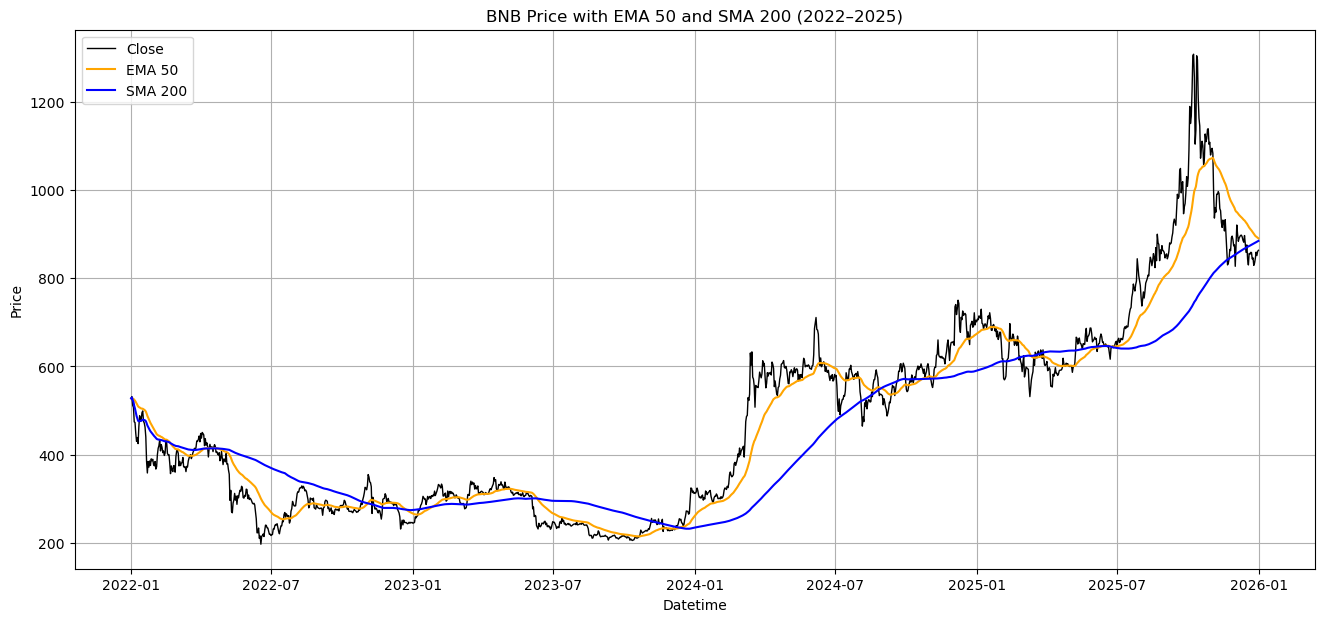

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,7))

plt.plot(pdf["datetime"], pdf["close"], label="Close", color="black", linewidth=1)
plt.plot(pdf["datetime"], pdf["EMA_50"], label="EMA 50", color="orange", linewidth=1.5)
plt.plot(pdf["datetime"], pdf["SMA_200"], label="SMA 200", color="blue", linewidth=1.5)

plt.title("BNB Price with EMA 50 and SMA 200 (2022–2025)")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.legend()
plt.grid(True)

plt.show()